<a href="https://colab.research.google.com/github/babatundeibukun/DEEP-LEARNING-PROJECT---COMPUTER/blob/main/Copy_of_2_Node_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 27.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Node Classification with Graph Neural Networks

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


# losses = []
# epochs_recorded = []

# for epoch in range(1, 201):
#     loss = train()
#     acc = test()
#     if epoch % 10 == 0:
#         losses.append(loss.item())
#         epochs_recorded.append(epoch)

#         print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")


losses = []
test_accuracies = []
epochs_recorded = []

for epoch in range(1, 201):
    loss = train()
    test_acc = test(data.test_mask)

    if epoch % 10 == 0:
        losses.append(loss.item())
        test_accuracies.append(test_acc)
        epochs_recorded.append(epoch)

        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}")



<IPython.core.display.Javascript object>

Epoch: 010, Loss: 1.8893, Test: 0.1830
Epoch: 020, Loss: 1.7441, Test: 0.4650
Epoch: 030, Loss: 1.5020, Test: 0.5120
Epoch: 040, Loss: 1.2543, Test: 0.5350
Epoch: 050, Loss: 1.0563, Test: 0.5360
Epoch: 060, Loss: 0.8578, Test: 0.5590
Epoch: 070, Loss: 0.6864, Test: 0.5630
Epoch: 080, Loss: 0.6368, Test: 0.5680
Epoch: 090, Loss: 0.5520, Test: 0.5690
Epoch: 100, Loss: 0.5350, Test: 0.5670
Epoch: 110, Loss: 0.4908, Test: 0.5710
Epoch: 120, Loss: 0.4745, Test: 0.5750
Epoch: 130, Loss: 0.4603, Test: 0.5790
Epoch: 140, Loss: 0.4031, Test: 0.5810
Epoch: 150, Loss: 0.4212, Test: 0.5880
Epoch: 160, Loss: 0.3782, Test: 0.5940
Epoch: 170, Loss: 0.3704, Test: 0.5900
Epoch: 180, Loss: 0.4203, Test: 0.5910
Epoch: 190, Loss: 0.3912, Test: 0.5880
Epoch: 200, Loss: 0.3810, Test: 0.5900


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [ ]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


As one can see, our MLP performs rather bad with only about 59% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)





GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

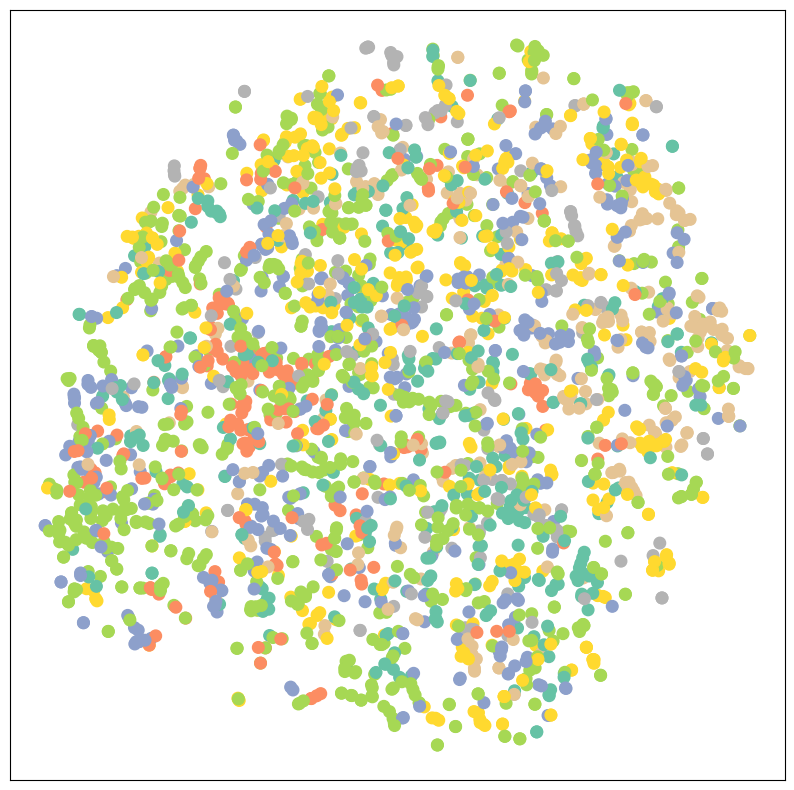

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


losses = []
test_accuracies = []
epochs_recorded = []

for epoch in range(1, 201):
    loss = train()
    test_acc = test(data.test_mask)

    if epoch % 10 == 0:
        losses.append(loss.item())
        test_accuracies.append(test_acc)
        epochs_recorded.append(epoch)

        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}")

<IPython.core.display.Javascript object>

Epoch: 010, Loss: 1.8685, Test: 0.4470
Epoch: 020, Loss: 1.7310, Test: 0.6560
Epoch: 030, Loss: 1.5576, Test: 0.7210
Epoch: 040, Loss: 1.3258, Test: 0.7800
Epoch: 050, Loss: 1.1296, Test: 0.7940
Epoch: 060, Loss: 0.9741, Test: 0.8000
Epoch: 070, Loss: 0.7711, Test: 0.8070
Epoch: 080, Loss: 0.6755, Test: 0.8130
Epoch: 090, Loss: 0.6535, Test: 0.8130
Epoch: 100, Loss: 0.5799, Test: 0.8150
Epoch: 110, Loss: 0.5377, Test: 0.8160
Epoch: 120, Loss: 0.4883, Test: 0.8150
Epoch: 130, Loss: 0.4183, Test: 0.8100
Epoch: 140, Loss: 0.3921, Test: 0.8120
Epoch: 150, Loss: 0.4069, Test: 0.8080
Epoch: 160, Loss: 0.3510, Test: 0.8100
Epoch: 170, Loss: 0.3357, Test: 0.8120
Epoch: 180, Loss: 0.3497, Test: 0.8110
Epoch: 190, Loss: 0.3748, Test: 0.8100
Epoch: 200, Loss: 0.3045, Test: 0.8020


After training the model, we can check its test accuracy:

In [ ]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8020


**There it is!**
By simply swapping the linear layers with GNN layers, we can reach **81.5% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

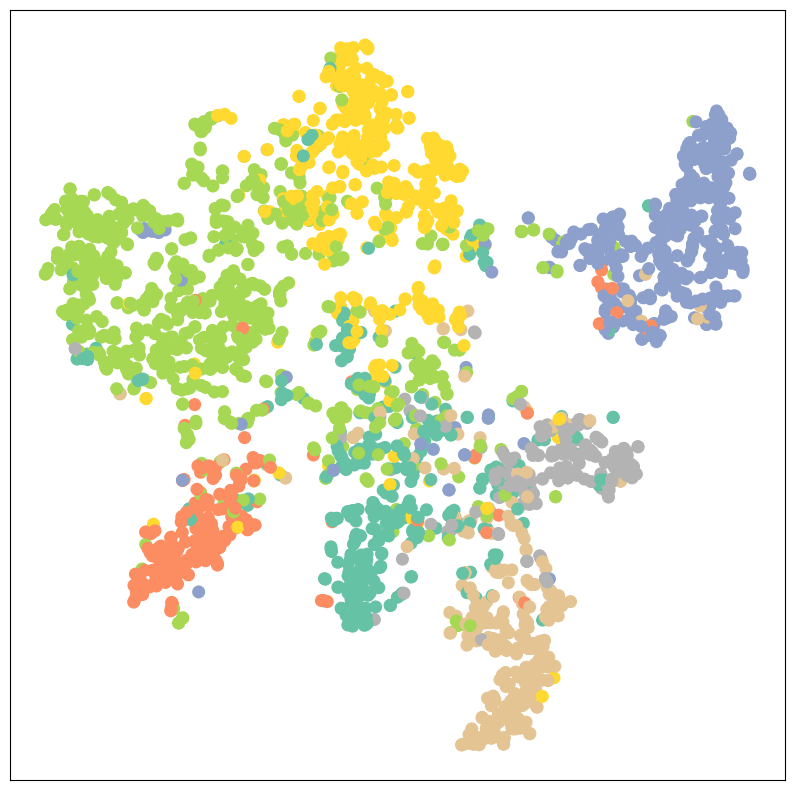

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Conclusion

In this chapter, you have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance.
In the next section, we will look into how GNNs can be used for the task of graph classification.

[Next: Graph Classification with Graph Neural Networks](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb)

## (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?

3. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

In [ ]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(...)  # TODO
        self.conv2 = GATConv(...)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

In [ ]:
def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc


#Modify the code to select and test the model with the highest validation performance.

In [ ]:
best_val_acc = 0
best_test_acc = 0
best_model_state = None  # store weights of best model

# To store for plotting if needed
losses = []
val_accuracies = []
test_accuracies = []
epochs_recorded = []

for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        best_model_state = model.state_dict()

    # Only print and record every 10 epochs
    if epoch % 10 == 0:
        losses.append(loss.item())
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)
        epochs_recorded.append(epoch)
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

# Load best model after training
model.load_state_dict(best_model_state)

print("\n✅ Best validation accuracy: {:.4f}".format(best_val_acc))
print("🎯 Test accuracy from best model: {:.4f}".format(best_test_acc))






Epoch 010 | Loss: 0.3127 | Val Acc: 0.8000 | Test Acc: 0.8000
Epoch 020 | Loss: 0.3564 | Val Acc: 0.8110 | Test Acc: 0.8110
Epoch 030 | Loss: 0.3062 | Val Acc: 0.8090 | Test Acc: 0.8090
Epoch 040 | Loss: 0.2868 | Val Acc: 0.8020 | Test Acc: 0.8020
Epoch 050 | Loss: 0.3068 | Val Acc: 0.8000 | Test Acc: 0.8000
Epoch 060 | Loss: 0.2749 | Val Acc: 0.8050 | Test Acc: 0.8050
Epoch 070 | Loss: 0.2788 | Val Acc: 0.8080 | Test Acc: 0.8080
Epoch 080 | Loss: 0.2884 | Val Acc: 0.8030 | Test Acc: 0.8030
Epoch 090 | Loss: 0.2384 | Val Acc: 0.8050 | Test Acc: 0.8050
Epoch 100 | Loss: 0.2491 | Val Acc: 0.8050 | Test Acc: 0.8050
Epoch 110 | Loss: 0.2345 | Val Acc: 0.8070 | Test Acc: 0.8070
Epoch 120 | Loss: 0.2330 | Val Acc: 0.8080 | Test Acc: 0.8080
Epoch 130 | Loss: 0.2542 | Val Acc: 0.8110 | Test Acc: 0.8110
Epoch 140 | Loss: 0.2322 | Val Acc: 0.8080 | Test Acc: 0.8080
Epoch 150 | Loss: 0.2369 | Val Acc: 0.8090 | Test Acc: 0.8090
Epoch 160 | Loss: 0.2487 | Val Acc: 0.8030 | Test Acc: 0.8030
Epoch 17

# Increasing the hidden feature dimensionality or the number of layers? Does increasing the number of layers help at all?

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)       # 1433 → 16
        self.conv2 = GCNConv(hidden_channels, hidden_channels)            # 16 → 16
        self.conv3 = GCNConv(hidden_channels, dataset.num_classes)        # 16 → 7




    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x



model = GCN(hidden_channels=16)
print(model)



GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 7)
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


best_val_acc = 0
best_test_acc = 0
best_model_state = None  # store weights of best model

# To store for plotting if needed
losses = []
val_accuracies = []
test_accuracies = []
epochs_recorded = []

for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        best_model_state = model.state_dict()

    # Only print and record every 10 epochs
    if epoch % 10 == 0:
        losses.append(loss.item())
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)
        epochs_recorded.append(epoch)
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

# Load best model after training
model.load_state_dict(best_model_state)

print("\n✅ Best validation accuracy: {:.4f}".format(best_val_acc))
print("🎯 Test accuracy from best model: {:.4f}".format(best_test_acc))

Epoch 010 | Loss: 1.9125 | Val Acc: 0.4140 | Test Acc: 0.4380
Epoch 020 | Loss: 1.8370 | Val Acc: 0.5320 | Test Acc: 0.5090
Epoch 030 | Loss: 1.6831 | Val Acc: 0.6160 | Test Acc: 0.6030
Epoch 040 | Loss: 1.4479 | Val Acc: 0.6600 | Test Acc: 0.6720
Epoch 050 | Loss: 1.1828 | Val Acc: 0.7100 | Test Acc: 0.7290
Epoch 060 | Loss: 0.9515 | Val Acc: 0.7660 | Test Acc: 0.7640
Epoch 070 | Loss: 0.7195 | Val Acc: 0.7740 | Test Acc: 0.7720
Epoch 080 | Loss: 0.5466 | Val Acc: 0.7820 | Test Acc: 0.7960
Epoch 090 | Loss: 0.3980 | Val Acc: 0.7960 | Test Acc: 0.8030
Epoch 100 | Loss: 0.3338 | Val Acc: 0.7940 | Test Acc: 0.8060
Epoch 110 | Loss: 0.2607 | Val Acc: 0.7920 | Test Acc: 0.8060
Epoch 120 | Loss: 0.2540 | Val Acc: 0.7920 | Test Acc: 0.7980
Epoch 130 | Loss: 0.2234 | Val Acc: 0.7960 | Test Acc: 0.8060
Epoch 140 | Loss: 0.2164 | Val Acc: 0.8080 | Test Acc: 0.8090
Epoch 150 | Loss: 0.2005 | Val Acc: 0.7920 | Test Acc: 0.8080
Epoch 160 | Loss: 0.1816 | Val Acc: 0.7940 | Test Acc: 0.7980
Epoch 17

#GATCONV

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)

        # First GAT layer: 8 heads × 8 features = 64 output features
        self.conv1 = GATConv(
            in_channels=dataset.num_features,
            out_channels=hidden_channels,
            heads=heads,
            dropout=0.6
        )

        # Second GAT layer: 1 head × 7 classes
        self.conv2 = GATConv(
            in_channels=hidden_channels * heads,  # = 8 * 8 = 64
            out_channels=dataset.num_classes,
            heads=1,
            concat=False,
            dropout=0.6
        )

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
model = GAT(hidden_channels=8, heads=8)
print(model)


GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc


In [ ]:
best_val_acc = 0
best_test_acc = 0
best_model_state = None

for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        best_model_state = model.state_dict()

    print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

model.load_state_dict(best_model_state)
print("\n✅ Best validation accuracy: {:.4f}".format(best_val_acc))
print("🎯 Test accuracy from best model: {:.4f}".format(best_test_acc))


Epoch 001 | Loss: 1.9429 | Val Acc: 0.1020 | Test Acc: 0.1110
Epoch 002 | Loss: 1.9383 | Val Acc: 0.0740 | Test Acc: 0.0790
Epoch 003 | Loss: 1.9299 | Val Acc: 0.0800 | Test Acc: 0.0880
Epoch 004 | Loss: 1.9304 | Val Acc: 0.0940 | Test Acc: 0.1030
Epoch 005 | Loss: 1.9177 | Val Acc: 0.1260 | Test Acc: 0.1390
Epoch 006 | Loss: 1.9124 | Val Acc: 0.1920 | Test Acc: 0.2210
Epoch 007 | Loss: 1.9073 | Val Acc: 0.3160 | Test Acc: 0.3540
Epoch 008 | Loss: 1.8998 | Val Acc: 0.4500 | Test Acc: 0.4690
Epoch 009 | Loss: 1.8949 | Val Acc: 0.4880 | Test Acc: 0.5210
Epoch 010 | Loss: 1.8843 | Val Acc: 0.5260 | Test Acc: 0.5440
Epoch 011 | Loss: 1.8819 | Val Acc: 0.5480 | Test Acc: 0.5500
Epoch 012 | Loss: 1.8664 | Val Acc: 0.5620 | Test Acc: 0.5610
Epoch 013 | Loss: 1.8625 | Val Acc: 0.5720 | Test Acc: 0.5670
Epoch 014 | Loss: 1.8506 | Val Acc: 0.5780 | Test Acc: 0.5750
Epoch 015 | Loss: 1.8493 | Val Acc: 0.6040 | Test Acc: 0.5870
Epoch 016 | Loss: 1.8390 | Val Acc: 0.6200 | Test Acc: 0.6100
Epoch 01

In [ ]:
best_val_acc = 0
best_test_acc = 0
best_model_state = None  # store weights of best model

# To store for plotting if needed
losses = []
val_accuracies = []
test_accuracies = []
epochs_recorded = []

for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        best_model_state = model.state_dict()

    # Only print and record every 10 epochs
    if epoch % 10 == 0:
        losses.append(loss.item())
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)
        epochs_recorded.append(epoch)
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

# Load best model after training
model.load_state_dict(best_model_state)

print("\n✅ Best validation accuracy: {:.4f}".format(best_val_acc))
print("🎯 Test accuracy from best model: {:.4f}".format(best_test_acc))


Epoch 010 | Loss: 0.7103 | Val Acc: 0.8060 | Test Acc: 0.8170
Epoch 020 | Loss: 0.5679 | Val Acc: 0.8100 | Test Acc: 0.8260
Epoch 030 | Loss: 0.6822 | Val Acc: 0.8000 | Test Acc: 0.8210
Epoch 040 | Loss: 0.7125 | Val Acc: 0.7980 | Test Acc: 0.8230
Epoch 050 | Loss: 0.5434 | Val Acc: 0.8060 | Test Acc: 0.8160
Epoch 060 | Loss: 0.6317 | Val Acc: 0.8060 | Test Acc: 0.8210
Epoch 070 | Loss: 0.6204 | Val Acc: 0.8080 | Test Acc: 0.8220
Epoch 080 | Loss: 0.6665 | Val Acc: 0.8080 | Test Acc: 0.8280
Epoch 090 | Loss: 0.5977 | Val Acc: 0.7980 | Test Acc: 0.8090
Epoch 100 | Loss: 0.6250 | Val Acc: 0.8080 | Test Acc: 0.8250
Epoch 110 | Loss: 0.6728 | Val Acc: 0.8060 | Test Acc: 0.8210
Epoch 120 | Loss: 0.6212 | Val Acc: 0.8040 | Test Acc: 0.8180
Epoch 130 | Loss: 0.5690 | Val Acc: 0.7940 | Test Acc: 0.8230
Epoch 140 | Loss: 0.5791 | Val Acc: 0.8100 | Test Acc: 0.8250
Epoch 150 | Loss: 0.6362 | Val Acc: 0.7960 | Test Acc: 0.8190
Epoch 160 | Loss: 0.6612 | Val Acc: 0.7940 | Test Acc: 0.8260
Epoch 17

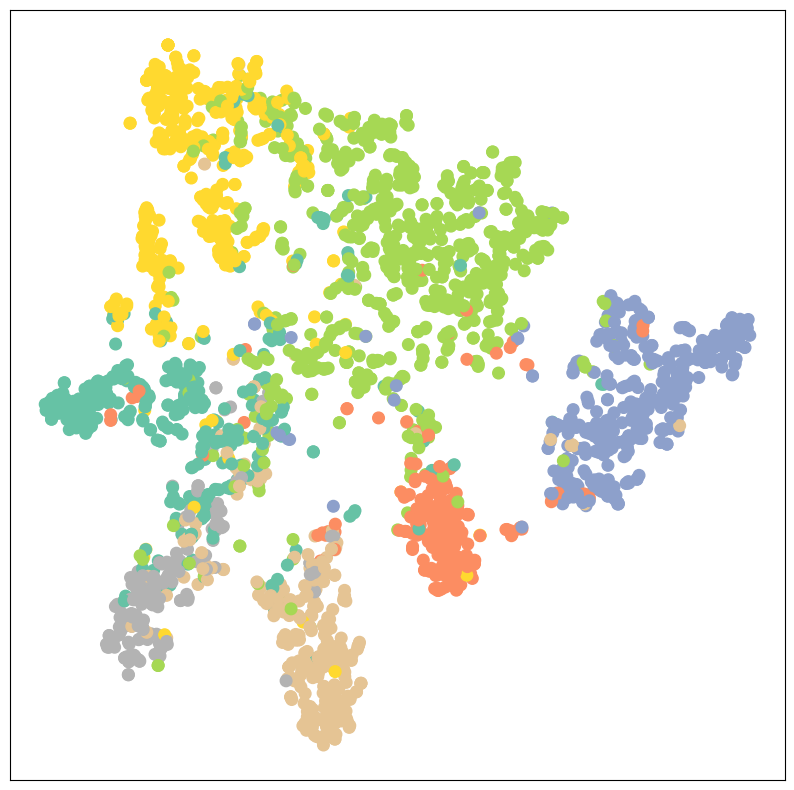

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

the diagram to add to my sop

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)

        self.conv1 = GATConv(
            in_channels=dataset.num_features,
            out_channels=hidden_channels,
            heads=heads,
            dropout=0.6
        )

        self.conv2 = GATConv(
            in_channels=hidden_channels * heads,
            out_channels=dataset.num_classes,
            heads=1,
            concat=False,
            dropout=0.6
        )

    def forward(self, x, edge_index, return_attention=False):
        x = F.dropout(x, p=0.6, training=self.training)

        if return_attention:
            x, attn_weights = self.conv1(x, edge_index, return_attention_weights=True)
        else:
            x = self.conv1(x, edge_index)

        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        if return_attention:
            return x, attn_weights
        return x


In [ ]:
model = GAT(hidden_channels=8, heads=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

# ✅ Train for 200 epochs
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f}")


Epoch 020 | Loss: 1.7936
Epoch 040 | Loss: 1.5597
Epoch 060 | Loss: 1.2244
Epoch 080 | Loss: 1.0986
Epoch 100 | Loss: 1.0030
Epoch 120 | Loss: 0.7966
Epoch 140 | Loss: 0.8025
Epoch 160 | Loss: 0.7985
Epoch 180 | Loss: 0.6619
Epoch 200 | Loss: 0.7410


In [ ]:
model.eval()
with torch.no_grad():
    out, attn_weights = model(data.x, data.edge_index, return_attention=True)

edge_index, alpha = attn_weights
alpha = alpha.mean(dim=1)  # Average over 8 heads


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


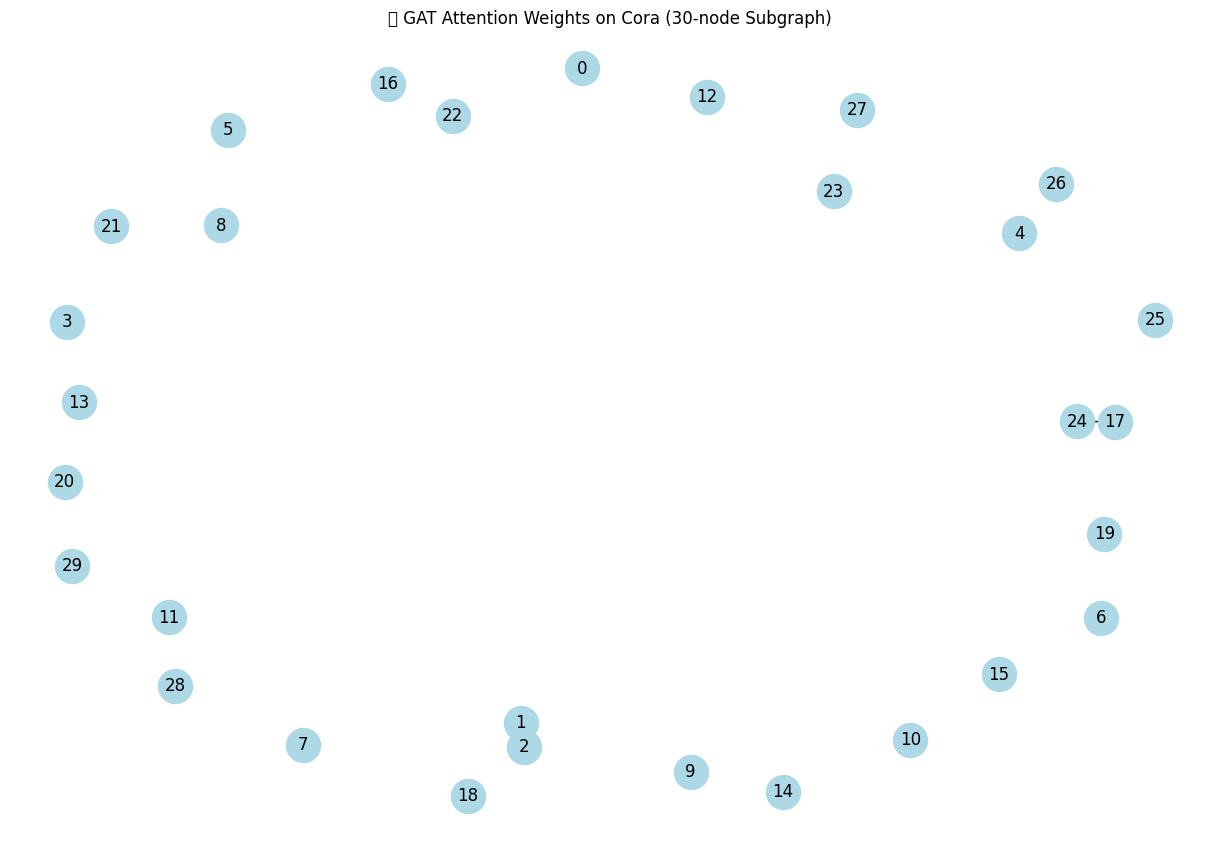

In [ ]:
# Convert to NetworkX graph
G = to_networkx(data, to_undirected=True)

# Select a small subgraph (first 30 nodes)
sub_nodes = list(range(30))
subgraph = G.subgraph(sub_nodes)
edge_list = edge_index.t().tolist()

# Map alpha weights to edges in the subgraph
edge_alpha_map = {}
for i, (src, dst) in enumerate(edge_list):
    if src in sub_nodes and dst in sub_nodes:
        edge_alpha_map[(src, dst)] = float(alpha[i])

# Draw graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)

# Nodes
nx.draw(subgraph, pos, node_color='lightblue', with_labels=True, node_size=600)

# Edges with attention weights as opacity
for edge in subgraph.edges():
    attn = edge_alpha_map.get(edge, 0.1)
    nx.draw_networkx_edges(subgraph, pos, edgelist=[edge], width=2, alpha=attn, edge_color='red')

plt.title("🔍 GAT Attention Weights on Cora (30-node Subgraph)")
plt.show()


#GraphSage

In [ ]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
model = GraphSAGE(hidden_channels=16)


In [ ]:
best_val_acc = 0
best_test_acc = 0

for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc

    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

print(f"\n✅ Best validation accuracy: {best_val_acc:.4f}")
print(f"🎯 Test accuracy from best model: {best_test_acc:.4f}")


Epoch 020 | Loss: 1.9578 | Val Acc: 0.0720 | Test Acc: 0.0910
Epoch 040 | Loss: 1.9573 | Val Acc: 0.0720 | Test Acc: 0.0910
Epoch 060 | Loss: 1.9565 | Val Acc: 0.0720 | Test Acc: 0.0910
Epoch 080 | Loss: 1.9571 | Val Acc: 0.0720 | Test Acc: 0.0910
Epoch 100 | Loss: 1.9565 | Val Acc: 0.0720 | Test Acc: 0.0910
Epoch 120 | Loss: 1.9576 | Val Acc: 0.0720 | Test Acc: 0.0910
Epoch 140 | Loss: 1.9576 | Val Acc: 0.0720 | Test Acc: 0.0910
Epoch 160 | Loss: 1.9574 | Val Acc: 0.0720 | Test Acc: 0.0910
Epoch 180 | Loss: 1.9577 | Val Acc: 0.0720 | Test Acc: 0.0910
Epoch 200 | Loss: 1.9568 | Val Acc: 0.0720 | Test Acc: 0.0910

✅ Best validation accuracy: 0.0720
🎯 Test accuracy from best model: 0.0910
